In [ ]:
%load_ext google.cloud.bigquery
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objects as go
import cufflinks as cf
import pyramid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from time import time
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from sklearn.impute import KNNImputer
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


# Importing the table from BigQuery

In [ ]:
from google.cloud import bigquery

client = bigquery.Client()
sql = """
HIDDEN
"""
df = client.query(sql).to_dataframe()
df = df.rename(columns={"HIDDEN"})
df2 = pd.read_csv("HIDDEN")

# Modifying the table by dropping unneeded columns and setting the index to Date.

In [ ]:
df = pd.read_csv("HIDDEN.csv")

# Seasonality and trend checking

In [ ]:

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.asfreq(df.index.freq)
# Modifying Neste data to monthly data
df = df.resample('M').sum()

#Dropping unneeded dates
df = df.drop(pd.date_range('2016-01-01', '2018-01-01'), errors='ignore')
df = df[:-5]
#Bugfix CSV:s
df.to_csv('df1.csv', index = True, header=True)
df2.to_csv('df2.csv', index = True, header=True)


In [ ]:
df.to_csv('export.csv', index = True, header=True)

# Auto ARIMA, model fit and predictions

In [ ]:
#Change seasonal from true to false if need for ARIMA, also change m according to the seasonality pattern
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(df, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=None, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=3154.709, BIC=3166.210, Time=0.046 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=3211.262, BIC=3217.013, Time=0.010 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=3154.967, BIC=3163.592, Time=0.023 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=3182.802, BIC=3191.428, Time=0.025 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=3808.438, BIC=3811.313, Time=0.007 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=3150.263, BIC=3164.639, Time=0.302 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=3151.089, BIC=3162.590, Time=0.039 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=3136.452, BIC=3153.704, Time=0.172 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=3138.378, BIC=3152.754, Time=0.096 seconds
Fit ARIMA(4,0,1)x(0,0,0,0) [intercept=True]; AIC=3130.391, BIC=3150.517, Time=0.285 seconds
Fit ARIMA(4,0,0)x(0,0,0,0) [intercep

In [ ]:
#Splitting the data to training and test sets
train_end = datetime(2019,6,30)
test_end = datetime(2019,12,31)

train_data = df[:train_end]
test_data = df[train_end + timedelta(days=1):test_end]

In [ ]:
#Fitting the parameters and the data into the ARIMA model
stepwise_model.fit(train_data)

ARIMA(maxiter=50, method='lbfgs', order=(5, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
#Predicting n periods forward
future_forecast = stepwise_model.predict(n_periods=6)
future_forecast = pd.DataFrame(future_forecast,index = test_data.index,columns=['Prediction'])

# Outputs

In [ ]:
print(stepwise_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -1482.075
Date:                Tue, 16 Jun 2020   AIC                           2978.150
Time:                        12:11:09   BIC                           2997.948
Sample:                             0   HQIC                          2986.193
                                - 125                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.033e+05   3.88e+04      5.241      0.000    1.27e+05    2.79e+05
ar.L1          0.4850      0.078      6.227      0.000       0.332       0.638
ar.L2          0.5635      0.095      5.923      0.0

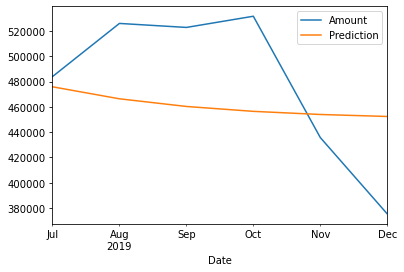

In [ ]:
#Testing by plotting the forecasted and real data
pd.concat([test_data,future_forecast],axis=1).plot()

# Diagnostics

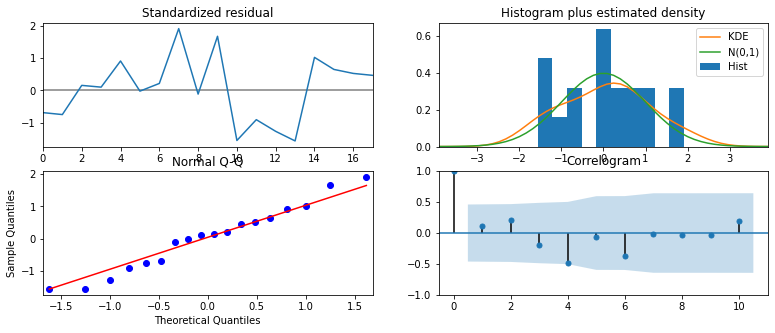

In [ ]:
stepwise_model.plot_diagnostics(figsize=(13,5))
plt.show()

# Predicting forward

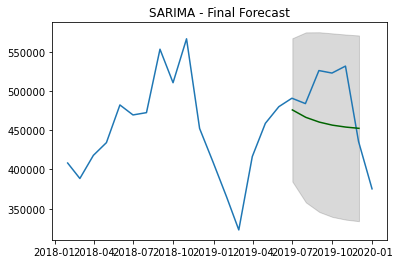

In [ ]:
# Forecast
n_periods = 6
fitted, confint = stepwise_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train_data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast")
plt.show()

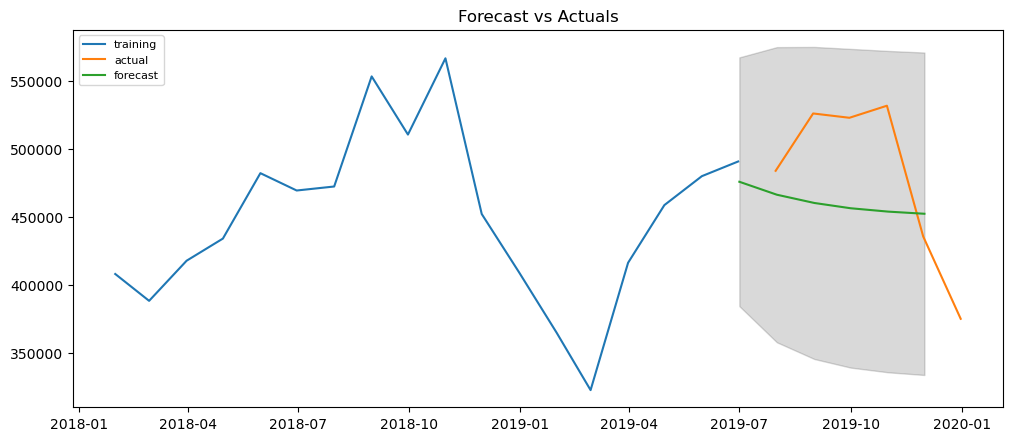

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(fitted_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_data, fitted_series)
print('MAE: %f' % mae)

MAE: 50146.016115
